# Prerequisites

In [1]:
%load_ext autoreload
%autoreload 2

import glob
import json
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms
import box_ops
from data import WasteSet, get_waste, standardize_inv
from PIL import Image
from selectivesearch import SelectiveSearch
from tqdm.notebook import tqdm
from utils import show_annotation, show_cmap, filter_and_label_proposals

data_path = '/dtu/datasets1/02514/data_wastedetection'

# Dataloader

In [2]:
train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader = get_waste(
    8, num_workers=8, data_augmentation=True, supercategories=True)

len(train_dataset), len(val_dataset), len(test_dataset)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


(1050, 225, 225)

In [3]:
ims, targets = next(iter(train_loader))
len(ims), len(targets)

(8, 8)

In [4]:
targets[0]

{'bboxes_unit': tensor([[0.3738, 0.4093, 0.2426, 0.0977]]),
 'bboxes': tensor([[191.4003, 372.4285, 124.2303,  88.9100]]),
 'category_ids': tensor([7]),
 'size': (910, 512)}

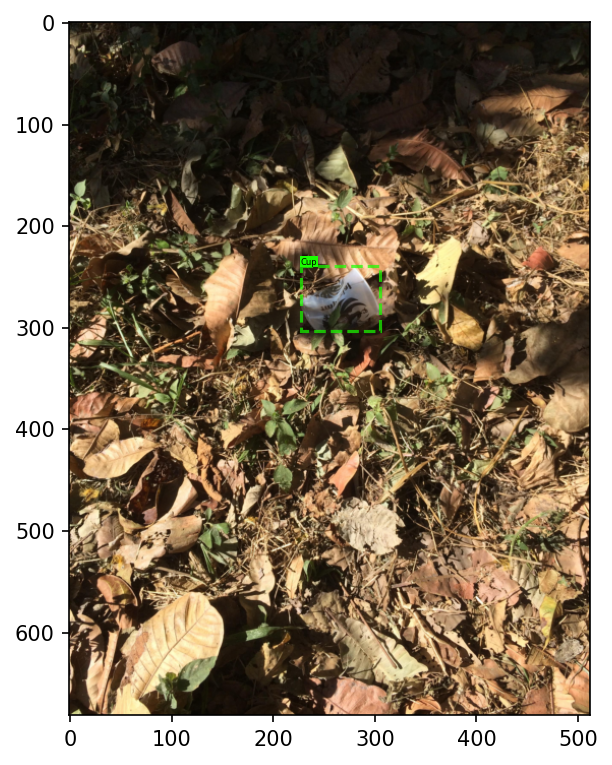

In [5]:
idx = 7

im, _ = standardize_inv(ims[idx], None)
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=150)
ax.imshow(np.moveaxis(im.numpy(), 0, 2))
show_annotation(targets[idx], ax, names=train_dataset.cat_names)

In [6]:
ims[2].shape

torch.Size([3, 512, 512])

# Object proposals

In [7]:
# Selective search module
ss = SelectiveSearch(mode='f', nkeep=400)

ims, targets = next(iter(train_loader))

In [8]:
# Get region proposals and preprocess them
proposals_batch = [ss((np.moveaxis(im.numpy(), 0, 2) * 255).astype(np.uint8)) for im in ims]

In [11]:
proposals_batch, proposals_batch_labels = filter_and_label_proposals(proposals_batch, targets)

In [12]:
# Merge with gt boxes
boxes_batch = [np.vstack((proposal_boxes, target['bboxes'].numpy())).round().astype(int)
               for proposal_boxes, target in zip(proposals_batch, targets)]
y_true = np.concatenate([np.concatenate((proposal_labels, target['category_ids'].numpy())) 
                for proposal_labels, target in zip(proposals_batch_labels, targets)])

In [17]:
y_true = torch.tensor(y_true)

resize = transforms.Resize((256, 256))
X = [resize.forward(im[:, y:y+h, x:x+w]) for im, boxes in zip(ims, boxes_batch) for x, y, w, h in boxes]
random.shuffle(X)
X = torch.stack(X)

/tmp/ipykernel_37312/1097339705.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(y_true)


In [19]:
X.shape, y_true.shape

(torch.Size([71, 3, 256, 256]), torch.Size([71]))